# Testing of the att_mcmc module's single-chain and naively parallelized samplers

In [1]:
from att_mcmc import *
import mcmc_utils as mcu
import plotting_functions as pfs
import numpy as np
import numpy.linalg as alg
import numpy.random as rnd
import matplotlib.pyplot as plt

In [2]:
n_chains = 10
n_burn = int(1e4)
n_its = int(1e5)
n_samples = n_chains * n_its

In [3]:
def plot_npatt_ada_progress(
        schedule,
        params,
        gt,
        pname,
        figsize=(4.5,3),
        dpi=100,
        filepath=None,
    ):
    """Plot NPATT's adaptation progress, i.e. the progression of the distance (in
        log-scale) between its tuning parameter and the underlying ground truth
        value that parameter aims to approximate. The distance underlying the
        presented values is the Euclidean distance between the (flattened, if
        necessary) parameter and ground truth vectors.
    """
    title = "Distance of Sample {} from True {}".format(pname, pname)
    n_ups = schedule.shape[0]
    params = params.reshape(n_chains,n_ups,-1)
    gt = gt.reshape(-1)
    devs = alg.norm(params - gt, axis=-1)
    default_cycler = plt.rcParams["axes.prop_cycle"]
    colors = plt.cm.viridis(np.linspace(0, 0.9, n_chains))
    plt.rcParams["axes.prop_cycle"] = plt.cycler("color", colors)
    pfs.initiate(figsize, dpi, title)
    plt.yscale("log")
    for i in range(n_chains):
        plt.plot(schedule, devs[i], alpha=0.75)
    pfs.wrapup(filepath)
    plt.rcParams["axes.prop_cycle"] = default_cycler

### ATT-GPSS

In [4]:
d = 100
x_0 = rnd.normal(scale=d, size=d)
w_burn = d**2
w_att = d

In [5]:
c = np.arange(d)

# multivariate Cauchy distribution with substantially non-zero center but trivial shape parameter
def log_density(x):
    return -(d+1)/2 * np.log(1 + alg.norm(x - c)**2)

In [6]:
ret_dic = att_gpss(
    log_density,
    n_burn,
    n_its,
    x_0,
    cen_mode="medi",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for sampling...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


100%|█████████████████████████████████| 100001/100001 [00:22<00:00, 4384.31it/s]

Assembling output...


In [7]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
medians = ret_dic['medians']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [8]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), its/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_its / np.sum(runtimes, axis=0)))

TDE/it: 22.70 (standard dev: 1132.66), its/s: 4390


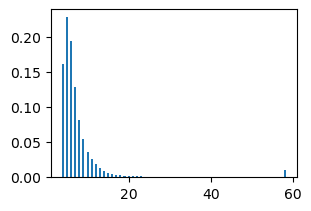

In [9]:
maxcnt = int(np.quantile(tde_cnts, 0.99))
filtered_tde_cnts = np.array([np.min([cnt, maxcnt]) for cnt in tde_cnts[1:]])
pfs.plot_tde_distr(filtered_tde_cnts)

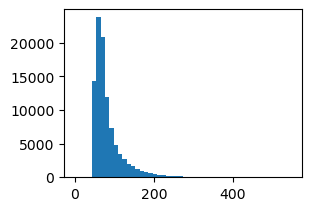

In [10]:
pfs.plot_runtime_hist(runtimes, nbins=50, cutoff_quant=0.99)

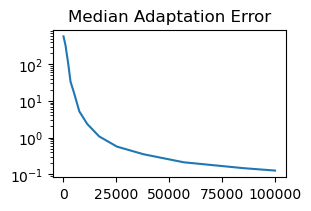

In [11]:
pfs.plot_ada_progress_testing(schedule, medians, c, "Median")

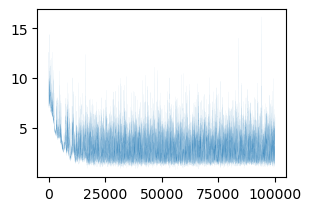

In [12]:
log_dist_from_c = mcu.get_log_radii(samples - c)
pfs.trace_plot(log_dist_from_c)

### ATT-HRUSS

In [13]:
d = 37
x_0 = rnd.normal(scale=1, size=d)
w_burn = d
w_att = d

In [14]:
std = np.arange(1,d+1)

# mean zero Gaussian with highly inconsistent coordinate variances
def log_density(x):
    return -alg.norm(x / std)**2 / 2

In [15]:
ret_dic = att_hruss(
    log_density,
    n_burn,
    n_its,
    x_0,
    cov_mode="var",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for sampling...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


100%|████████████████████████████████| 100001/100001 [00:05<00:00, 17321.77it/s]

Assembling output...


In [16]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
std_devs = ret_dic['std_devs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [17]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), its/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_its / np.sum(runtimes, axis=0)))

TDE/it: 6.77 (standard dev: 2.55), its/s: 17433


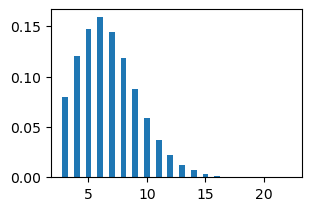

In [18]:
pfs.plot_tde_distr(tde_cnts[1:])

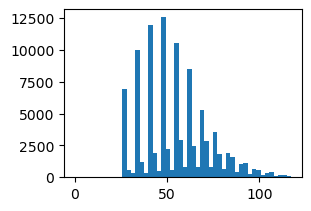

In [19]:
pfs.plot_runtime_hist(runtimes, nbins=50, cutoff_quant=0.99)

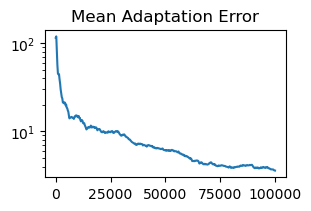

In [20]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

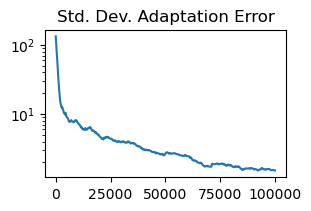

In [21]:
pfs.plot_ada_progress_testing(schedule, std_devs, std, "Std. Dev.")

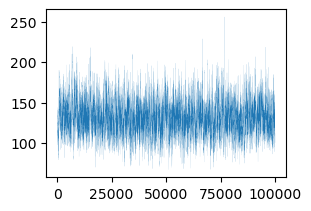

In [22]:
radii = mcu.get_radii(samples)
pfs.trace_plot(radii, lw=0.05)

### ATT-RSUSS

In [23]:
d = 29
x_0 = rnd.normal(scale=1, size=d)
w_burn = 1
w_att = 1

In [24]:
corr = 0.95
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

# mean zero Gaussian with strongly correlated variables
def log_density(x):
    return -np.inner(x, inv_cov @ x) / 2

In [25]:
ret_dic = att_rsuss(
    log_density,
    n_burn,
    n_its,
    x_0,
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att
)

Checking validity of given arguments...
Preparing for sampling...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


100%|████████████████████████████████| 100001/100001 [00:05<00:00, 18306.04it/s]

Assembling output...


In [26]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
covs = ret_dic['covs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [27]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), its/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_its / np.sum(runtimes, axis=0)))

TDE/it: 6.58 (standard dev: 1.51), its/s: 18415


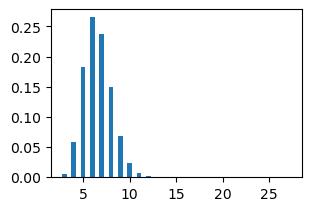

In [28]:
pfs.plot_tde_distr(tde_cnts[1:])

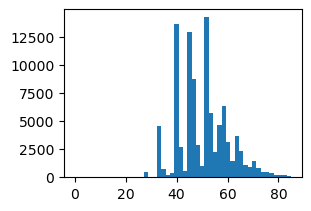

In [29]:
pfs.plot_runtime_hist(runtimes, nbins=50, cutoff_quant=0.99)

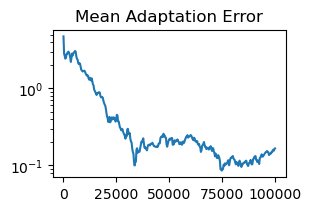

In [30]:
pfs.plot_ada_progress_testing(schedule, means, np.zeros(d), "Mean")

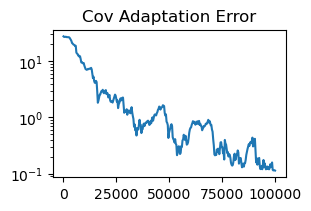

In [31]:
pfs.plot_ada_progress_testing(schedule, covs.reshape(-1, d*d), cov.reshape(-1, d*d), "Cov")

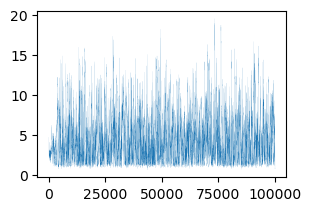

In [32]:
radii = mcu.get_radii(samples)
pfs.trace_plot(radii, lw=0.05)

### ATT-ESS

In [33]:
d = 23
x_0 = rnd.normal(scale=1, size=d)

In [34]:
c = np.full(d, np.sqrt(d))

# generalized Gaussian with somewhat non-zero mean but trivial covariance
def log_density(x):
    return -alg.norm(x - c)**3

In [35]:
ret_dic = att_ess(
    log_density,
    n_burn,
    n_its,
    x_0,
    cen_mode="mean",
)

Checking validity of given arguments...
Preparing for sampling...
Starting init burn-in sampling...
Preparing for ATT sampling...
Starting ATT sampling...


100%|█████████████████████████████████| 100001/100001 [00:11<00:00, 8555.03it/s]

Assembling output...


In [36]:
burn_in = ret_dic['burn-in']
tde_cnts_burn = ret_dic['tde_cnts_burn']
samples = ret_dic['samples']
means = ret_dic['means']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [37]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), its/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_its / np.sum(runtimes, axis=0)))

TDE/it: 5.47 (standard dev: 3.07), its/s: 8597


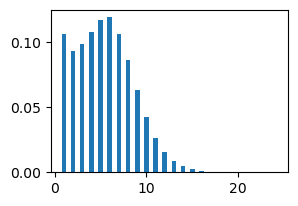

In [38]:
pfs.plot_tde_distr(tde_cnts[1:])

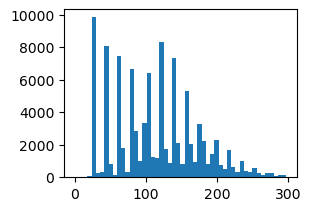

In [39]:
pfs.plot_runtime_hist(runtimes, nbins=50, cutoff_quant=0.99)

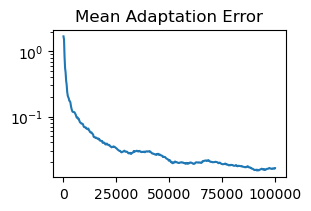

In [40]:
pfs.plot_ada_progress_testing(schedule, means, c, "Mean")

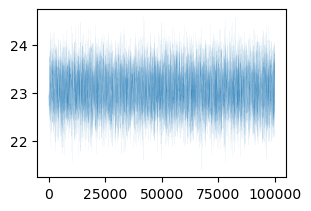

In [41]:
radii = mcu.get_radii(samples)
pfs.trace_plot(radii)

### NPATT-GPSS

In [42]:
d = 100
x_0s = rnd.normal(scale=d, size=(n_chains,d))
w_burn = d**2
w_att = d

In [43]:
c = np.arange(d)

# multivariate Cauchy distribution with substantially non-zero center but trivial shape parameter
def log_density(x):
    return -(d+1)/2 * np.log(1 + alg.norm(x - c)**2)

In [44]:
ret_dic = npatt_gpss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0s,
    cen_mode="medi",
    w_burn=w_burn,
    w_att=w_att
)

Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100001/100001 [00:16<00:00, 6179.17it/s]


Processing returns and assembling output...


In [45]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
medians = ret_dic['medians']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [46]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 9.38 (standard dev: 120.31), samples/s: 57947


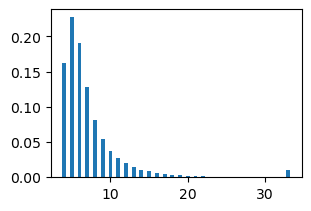

In [47]:
maxcnt = int(np.quantile(tde_cnts, 0.99))
filtered_tde_cnts = np.array([np.min([cnt, maxcnt]) for cnt in tde_cnts[1:].reshape(-1)])
pfs.plot_tde_distr(filtered_tde_cnts)

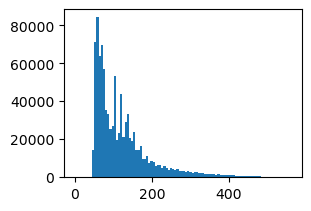

In [48]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

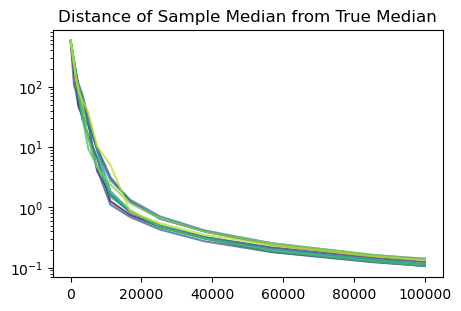

In [49]:
plot_npatt_ada_progress(schedule, medians, c, "Median")

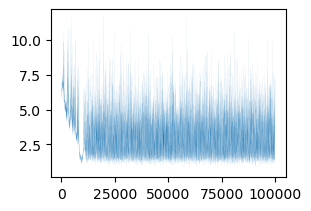

In [50]:
log_dist_from_c = mcu.get_log_radii(samples[:,0] - c)
pfs.trace_plot(log_dist_from_c)

### NPATT-HRUSS

In [51]:
d = 37
x_0 = rnd.normal(scale=1, size=(n_chains,d))
w_burn = d
w_att = d

In [52]:
std = np.arange(1,d+1)

# mean zero Gaussian with highly inconsistent coordinate variances
def log_density(x):
    return -alg.norm(x / std)**2 / 2

In [53]:
ret_dic = npatt_hruss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0,
    cov_mode="var",
    w_burn=w_burn,
    w_att=w_att
)

Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100001/100001 [00:10<00:00, 9615.88it/s]


Processing returns and assembling output...


In [54]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
std_devs = ret_dic['std_devs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [55]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 6.77 (standard dev: 2.54), samples/s: 104609


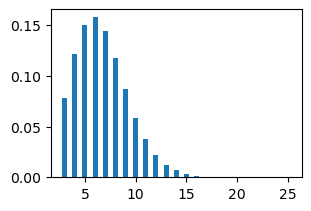

In [56]:
pfs.plot_tde_distr(tde_cnts[1:])

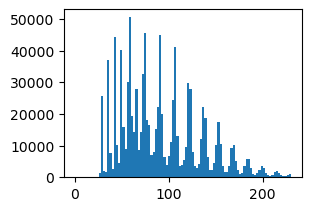

In [57]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

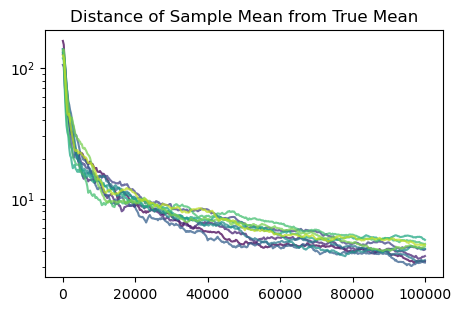

In [58]:
plot_npatt_ada_progress(schedule, means, np.zeros(d), "Mean")

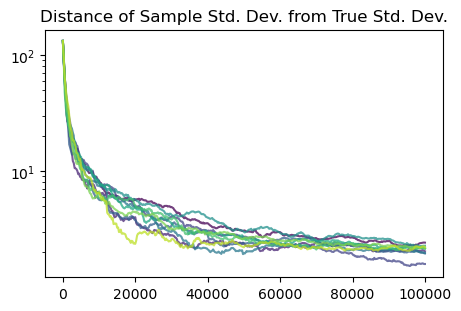

In [59]:
plot_npatt_ada_progress(schedule, std_devs, std, "Std. Dev.")

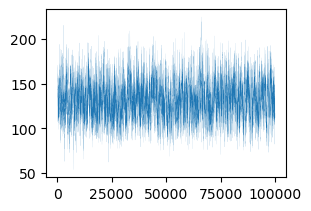

In [60]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### NPATT-RSUSS

In [61]:
d = 29
x_0 = rnd.normal(scale=1, size=(n_chains,d))
w_burn = 1
w_att = 1

In [62]:
corr = 0.95
cov = np.full((d,d), corr) + (1 - corr) * np.identity(d)
inv_cov = alg.inv(cov)

# mean zero Gaussian with strongly correlated variables
def log_density(x):
    return -np.inner(x, inv_cov @ x) / 2

In [63]:
ret_dic = npatt_rsuss(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0,
    cov_mode="cov",
    w_burn=w_burn,
    w_att=w_att
)

Preparing for parallel sampling...
Starting parallel sampling...


100%|████████████████████████████████| 100001/100001 [00:09<00:00, 10690.17it/s]


Processing returns and assembling output...


In [64]:
burn_in = ret_dic['burn-in']
samples = ret_dic['samples']
means = ret_dic['means']
covs = ret_dic['covs']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [65]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 6.58 (standard dev: 1.52), samples/s: 118854


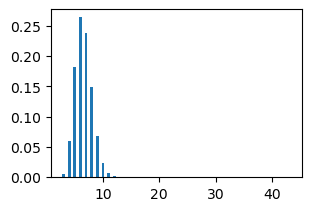

In [66]:
pfs.plot_tde_distr(tde_cnts[1:])

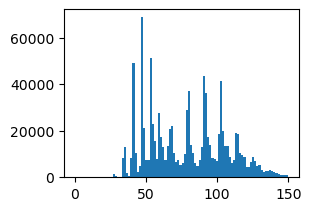

In [67]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

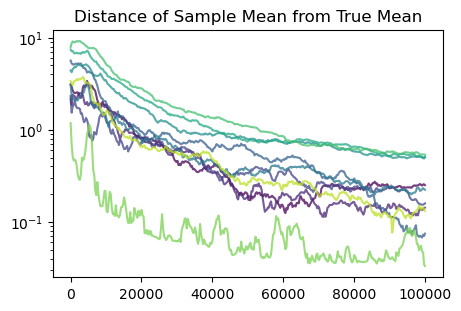

In [68]:
plot_npatt_ada_progress(schedule, means, np.zeros(d), "Mean")

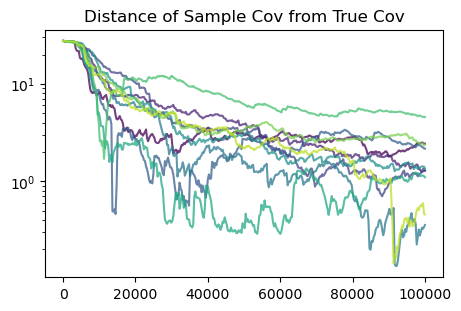

In [69]:
plot_npatt_ada_progress(schedule, covs.reshape(-1, d*d), cov.reshape(-1, d*d), "Cov")

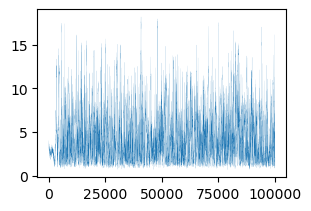

In [70]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii, lw=0.05)

### NPATT-ESS

In [71]:
d = 23
x_0 = rnd.normal(scale=1, size=(n_chains,d))

In [72]:
c = np.full(d, np.sqrt(d))

# generalized Gaussian with somewhat non-zero mean but trivial covariance
def log_density(x):
    return -alg.norm(x - c)**3

In [73]:
ret_dic = npatt_ess(
    log_density,
    n_chains,
    n_burn,
    n_its,
    x_0,
    cen_mode="mean",
)

Preparing for parallel sampling...
Starting parallel sampling...


100%|█████████████████████████████████| 100001/100001 [00:21<00:00, 4574.62it/s]


Processing returns and assembling output...


In [74]:
burn_in = ret_dic['burn-in']
tde_cnts_burn = ret_dic['tde_cnts_burn']
samples = ret_dic['samples']
means = ret_dic['means']
schedule = ret_dic['schedule']
tde_cnts = ret_dic['tde_cnts']
runtimes = ret_dic['runtimes']

In [75]:
print("TDE/it: {:.2f} (standard dev: {:.2f}), samples/s: {:.0f}".format(\
np.mean(tde_cnts[1:]), np.std(tde_cnts[1:]), n_samples / np.mean(np.sum(runtimes, axis=0))))

TDE/it: 5.47 (standard dev: 3.07), samples/s: 52508


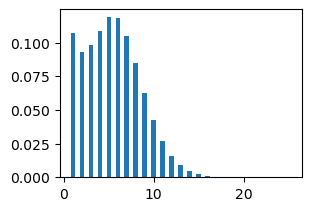

In [76]:
pfs.plot_tde_distr(tde_cnts[1:])

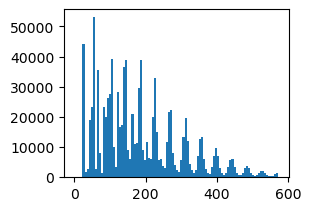

In [77]:
pfs.plot_runtime_hist(runtimes, cutoff_quant=0.99)

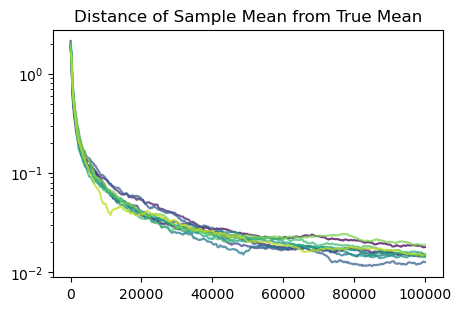

In [78]:
plot_npatt_ada_progress(schedule, means, c, "Mean")

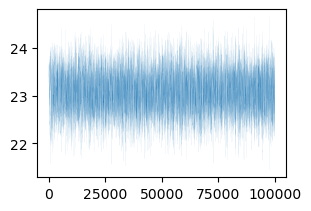

In [79]:
radii = mcu.get_radii(samples[:,0])
pfs.trace_plot(radii)